In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy.io as sio
import statsmodels.api as sm
from tqdm.notebook import tqdm
from glob import glob
from matplotlib import pyplot as plt

In [2]:
ll = 24
nsess = 24
nlist = 24*nsess
outputs = np.arange(ll)
lists = np.arange(nlist)
irt_lags = 4
beh_path = '/data/eeg/scalp/ltp/ltpFR2/behavioral/data/'
w2v_path = '/home1/shai.goldman/IRT_git/Scripts/Resources/w2v.mat'
w2v = sio.loadmat(w2v_path)['w2v']
data_keys = ['subject', 'session', 'good_trial', 'pres_words',
             'pres_nos', 'rec_words', 'rec_nos', 'recalled',
             'times', 'intrusions', 'recalls', 'lag', 'irt',
             'total_recalls', 'sem']

In [3]:
def load_data(filename=None, subject=None):
    
    if filename is None and subject is None:
        raise ValueError('filename and subject cannot both be None')
    elif subject is not None:
        filename = f'{beh_path}beh_data_{subject}.json'
        
    x = pd.read_json(filename)

    # convert data stats to pandas dfs with columns for
    # output position and rows for list number
    data = {}
    for key in x.keys():
        data[key] = np.array([i for i in x[key].values])
        if len(data[key].shape) > 1:
            data[key] = data[key][:, :ll]
            data[key] = np.pad(data[key],
                               [(0,0), (0,ll-data[key].shape[1])],
                               mode='edge')
            data[key] = pd.DataFrame(data[key], columns=outputs, index=lists)
        else:
            data[key] = pd.Series(data[key], index=lists)
    # I prefer the old naming convention for 'recalls' matrix
    data['recalls'] = data.pop('serialpos')
    
    return data

In [4]:
def get_lags(data):
    # calc serial lags
    prev_rec = data['recalls'].loc[:, :ll-2]
    prev_rec.columns = range(1,ll)
    return data['recalls'] - prev_rec

In [5]:
def strech_intrus(data):
    
    data = data.copy()
    
    # remove all recalls after the first intrusion in a list
    first_intrus = pd.Series([list(i).index(-1) if -1 in i
                                 else len(i) for i in data['recalls'].values],
                                index = lists
                               )

    for ls in data['recalls'].index:
        fi = first_intrus.loc[ls]
        data['recalls'].loc[ls, fi:] = 0
        data['times'].loc[ls, fi:] = 0
    
    return data

In [6]:
def get_irts(data):
    # calc irts
    prev_times = data['times'].loc[:,:ll-2].astype(float)
    prev_times.columns = range(1, ll)

    irts = data['times'] - prev_times
    irts[irts<=0] = np.nan
    return irts

In [7]:
def add_prev_irts(data, lags=irt_lags):
    # include prev irts into the data df
    
    for lag in range(1,lags+1):
        # shift all the irts by the lag
        prev_irts = data['irt'].loc[:, :ll-lag-1].copy()
        prev_irts[0] = 0 # change from NAN to zero
        prev_irts.columns = (outputs+lag)[:-lag]
        # insert [ZEROS] (nans) for outputs before the first lag
        for output in range(lag):
            prev_irts[output] = 0 #np.nan
        # resort columns since we added the first outputs to the end
        prev_irts = prev_irts[sorted(prev_irts.columns)]
        # input to data array
        data[f'irt-{lag}'] = prev_irts

In [8]:
def sem_sim(a, b):
    """ helper func for finding semantic sims. """
    if a <= 0 or b <= 0:
        return np.nan
    # the -1 is very important because of 0 indexing in python vs matlab
    # they originally started the rec_nos from index 1 when the lab was
    # matlab and to have a w2v matrix its going to start from index 0 in python
    return w2v[a-1, b-1]

In [9]:
def get_sems(data):
    # calc semantic similarities
    sims = [[sem_sim(row.loc[i-1], no) 
              if i>0 else np.nan
              for i, no in row.iteritems()]
             for r, row in data['rec_nos'].iterrows()]
    return pd.DataFrame(sims, index=lists, columns=outputs)

In [10]:
def ddata_path(subject, create=False):
    saves_dir = 'data/'
    if create and not os.path.exists(saves_dir):
        os.mkdir(saves_dir)
    saves_dir += subject +'/'
    if create and not os.path.exists(saves_dir):
        os.mkdir(saves_dir)
    return saves_dir

In [11]:
def save_data(data):
    """ Saves all the data to data/SUBJECT/ """
    subject = str(data['subject'].unique().squeeze())
    saves_dir = ddata_path(subject, create=True)
    for key in data:
        data[key].to_pickle(saves_dir+key+'.pkl')

In [12]:
def detailed_data(data, irt_lags=irt_lags, save=True):
    """ Add many important details to the data. """
    
    data = data.copy()
    
    data['lag'] = get_lags(data)
    
    # set all repeats as intrusions
    data['recalls'][data['lag']==0] = -1
    
    # remove all recs after an intrus
    data = strech_intrus(data)
    
    data['irt'] = get_irts(data)
    add_prev_irts(data, lags=irt_lags)
    
    # calc total recalls per list
    data['total_recalls'] = pd.Series(
        [r[r>0].size for i, r in data['recalls'].iterrows()],
        index=lists
    )
    
    data['sem'] = get_sems(data)
    
    if save:
        save_data(data)

    return data

In [22]:
def load_detailed_data(subject=None, path=None,
                       irt_lags=irt_lags, **kwargs):
    """ Loads detailed data if it exists, otherwise creates it."""
    # get data path
    if subject is None and path is None:
        raise ValueError('subject and path cannot both be None.')
    if subject is None:
        if '.json' in path:
            subject = file.split('beh_data_')[1].replace('.json', '')
        elif '.pkl' in path:
            path = '/'.join(path.split('/')[:-1])
    if subject is not None:
        path = ddata_path(subject, create=False)
    
    # load the data
    data = {}
    for filename in glob(path+'/*'):
        key = filename.split('/')[-1].replace('.pkl', '')
        data[key] = pd.read_pickle(filename)
    for key in data_keys:
        if not key in data:
            print('Not all data found. Loading data...')
            data = detailed_data(load_data(subject=subject),
                                 irt_lags=irt_lags, **kwargs)
            break
        
    # add missing lags
    for lag in range(1, irt_lags+1):
        if not f'irt-{lag}' in data:
            add_prev_irts(data, lags=irt_lags)
            break
            
    # remove extra lags
    lag_keys = [int(i.replace('irt-', '')) for i in data if 'irt-' in i]
    for lag in lag_keys:
        if lag > irt_lags:
            data.pop(f'irt-{lag}')
    
    return data

In [14]:
def prep_data_for_ols(data):
    # prepare data for OLS modeling by flattening it
    
    #-----flatten data----#
    flat_data = {}
    for key in data:
        if len(data[key].shape) > 1:
            flat_data[key] = data[key].values.flatten()
        else:
            flat_data[key] = np.repeat(data[key], ll).values.flatten()

    flat_data = pd.DataFrame(flat_data)
    
    # include output pos as a variable
    flat_data['output_pos'] = np.repeat([outputs], nlist, axis=0).flatten()

    #-----filter data----#
    # remove keys that wont go into the model
    for key in ['pres_words', 'pres_nos', 'rec_words',
                'rec_nos', 'recalled', 'times', 'intrusions',
                'subject', 'good_trial', 'recalls'
               ]:
        flat_data.pop(key)

    # remove all nans in prep for modeling
    for key in flat_data:
        flat_data = flat_data[~np.isnan(flat_data[key])]
        
    #----adjust some variables for the model----#
    # output position is inverted
    flat_data['output_pos'] = flat_data['output_pos'].astype(float)
    flat_data['output_pos'] = (ll-flat_data['output_pos']) ** -1
    # total recalls is normalized
    flat_data['total_recalls'] /= ll
    # lag is taken as ln(|lag|)
    flat_data['lag'] = np.log(np.abs(flat_data['lag']))
    
    # include lag sim interaction
    flat_data['lag_sem'] = flat_data['lag'] * flat_data['sem']
    
    return flat_data

In [15]:
def fit_model(flat_data):
    X = sm.add_constant(flat_data)
    y = X.pop('irt')

    model = sm.OLS(y, X)
    return model.fit()

In [16]:
def get_model(filename=None, subject=None, **kwargs):
    data = load_detailed_data(subject=subject, path=filename, **kwargs)
    flat_data = prep_data_for_ols(data)
    return fit_model(flat_data)

In [17]:
# get behavioral data for ltpFR2 all subjects
path = '/data/eeg/scalp/ltp/ltpFR2/behavioral/data/'
files = [f for f in glob(path+'beh_data_LTP*.json') if 'incomplete' not in f]

In [18]:
if 1:
    lags = range(1,10)
    aics = []
    bics = []
    for file in tqdm(files):
        subj = file.split('LTP')[1].replace('.json', '')
        models = [get_model(file, irt_lags=lag) for lag in lags]
        aics.append(pd.Series([m.aic for m in models], index=lags, name=subj))
        bics.append(pd.Series([m.bic for m in models], index=lags, name=subj))
    aics = pd.concat(aics, axis=1).transpose()
    bics = pd.concat(bics, axis=1).transpose()

Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading data...
Not all data found. Loading 

In [24]:
bics

,1,2,3,4,5,6,7,8,9
229,57403.914398,57411.789961,57419.073282,57423.555872,57424.659196,57432.317816,57439.832726,57447.251303,57454.566481
093,88467.323813,88475.589615,88479.222830,88487.594167,88495.004245,88498.732080,88507.128176,88515.163035,88498.159722
106,165375.769169,165366.588884,165370.634391,165374.200421,165380.410986,165377.119755,165354.504685,165331.883739,165336.668274
115,136250.612855,136250.514408,136247.860242,136244.412507,136251.950409,136229.342104,136223.062918,136226.547146,136222.640109
117,131793.893104,131790.952224,131784.186829,131780.106975,131782.051599,131770.578303,131777.887776,131774.699835,131749.657479
...,...,...,...,...,...,...,...,...,...
379,208744.658215,208746.494077,208752.411374,208754.745859,208756.831266,208753.334194,208760.860130,208769.101512,208777.675189
390,50802.630778,50809.601040,50817.332114,50822.554579,50828.319065,50835.609866,50842.612311,50850.102748,50856.637801
386,61398.868726,61402.164743,61405.291987,61412.283318,61419.674738,61424.269043,61432.182115,61425.680932,61431.169361
391,122745.805111,122751.894195,122750.977891,122756.802856,122760.674436,122754.539725,122760.347270,122761.526542,122769.047676


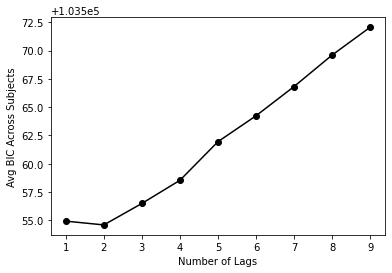

In [25]:
if 1:
    plt.errorbar(bics.columns, bics.mean(axis=0), #yerr=bics.sem(axis=0),
                 marker='o', color='k', label='BIC'
                )
    plt.xlabel('Number of Lags')
    plt.ylabel('Avg BIC Across Subjects')

In [20]:
file = files[0]
data = load_data(file)
data = detailed_data(data, 10)

In [21]:
data.keys()

dict_keys(['subject', 'session', 'good_trial', 'pres_words', 'pres_nos', 'rec_words', 'rec_nos', 'recalled', 'times', 'intrusions', 'recalls', 'lag', 'irt', 'irt-1', 'irt-2', 'irt-3', 'irt-4', 'irt-5', 'irt-6', 'irt-7', 'irt-8', 'irt-9', 'irt-10', 'total_recalls', 'sem'])